<h1>Astro 283 Homework 4</h1>
Bijan Pourhamzeh

<h3>Subtracting gaussian fit from the data</h3>
Below is the data subtracted by the single gaussian fit from the previous homework. Recall that the data was fit to a gaussian of the form
$$f(x,y,\vec{z}) = F\exp\left[-\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma_0^2}\right] + B$$
where $\vec{z} = (\sigma_0,x_0,y_0,F,B)$ is the vector of parameters we fit the data to via a least squares optimizer. We assume that the variance of the data is proportional to the data, so $\sigma_{x,y}^2 \propto D_{x,y}$.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from astropy.io import fits

In [2]:
#Import file and plot data

starfile = fits.open('hw3prob1-data.fits')
stardata = starfile[0].data
#plt.contourf(stardata)
#plt.colorbar()

In [3]:
#Gaussian fit from HW3

def gaussian_f(z,sig,x0,y0,F,B):
    #Model function to fit the data
    return F*np.exp(-1/(2*sig**2)*((z[0]-x0)**2+(z[1]-y0)**2)) + B

x_vals = np.linspace(0,stardata.shape[0]-1,stardata.shape[0])
y_vals = np.linspace(0,stardata.shape[1]-1,stardata.shape[1])
x_vals,y_vals = np.meshgrid(x_vals,y_vals)
ini_guess = (25.,125.,125.,80.,100.)
sigma_0 = np.sqrt(stardata)
popt, pcov = opt.curve_fit(gaussian_f, (x_vals.ravel(),y_vals.ravel()), stardata.ravel(), p0=ini_guess
                           , sigma=sigma_0.ravel())
print(popt)

[   7.12829056  125.97498933  132.4524456    26.19083029  133.01419728]


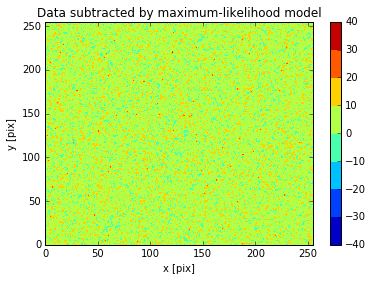

In [4]:
#Subtract Gaussian model from data

sig_f, x0_f, y0_f, F_f, B_f = popt
fit_nums = [[gaussian_f((xx,yy),sig_f,x0_f,y0_f,F_f,B_f) for xx in range(0,stardata.shape[0])] 
            for yy in range(0,stardata.shape[1])]
sub = stardata - fit_nums
plt.contourf(sub)
plt.colorbar()
plt.title('Data subtracted by maximum-likelihood model')
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')

<h3>Binary gaussian fit</h3>

Now we fit two gaussians to the data to test the hypothesis that there are two stars in the data. To do this, we fit the data to the function
$$f_2(x,y,\vec{z}) = F_1\exp\left[-\frac{(x-x_c-\frac{1}{2}r\cos\theta)^2 + (y-y_c-\frac{1}{2}r\sin\theta)^2}{2\sigma_0^2}\right] +  F_2\exp\left[-\frac{(x-x_c+\frac{1}{2}r\cos\theta)^2 + (y-y_c+\frac{1}{2}r\sin\theta)^2}{2\sigma_0^2}\right] + B$$
where $\vec{z} = (\sigma_0,x_c,y_c,r,\theta,F_1,F_2,B)$. The parameters $x_c,y_c$ are the center of the binary system, and $r,\theta$ are the length and angle with respect to $x$ of the line connecting the two stars. Here, we also assume that the variance of the data is proportional to the data, so $\sigma_{x,y} \propto D_{x,y}$. 

In [5]:
#Fit data to binary star model

def binary_gaussian_f(z,sig,xc,yc,r,theta,F1,F2,B):
    f1 = F1*np.exp(-0.5*((z[0]-xc-0.5*r*np.cos(theta))**2 + (z[1]-yc-0.5*r*np.sin(theta))**2)/sig**2)
    f2 = F2*np.exp(-0.5*((z[0]-xc+0.5*r*np.cos(theta))**2 + (z[1]-yc+0.5*r*np.sin(theta))**2)/sig**2)
    return f1 + f2 + B

ini_guess2 = [sig_f*0.5, x0_f, y0_f, 10., np.pi/4, F_f*0.5, F_f*0.5, B_f*0.5]
popt2, pcov2 = opt.curve_fit(binary_gaussian_f, (x_vals.ravel(), y_vals.ravel()), stardata.ravel(), 
                           p0=ini_guess2, sigma=sigma_0.ravel())
print(popt2)

[   6.11447468  128.39061119  134.79719517   11.94072753    0.77165792
   10.80667966   25.3423442   133.01264092]


<h3>Model comparison</h3>

To compare the binary and single star models, we compute the ratio of the posteriors for each model, given by
$$\frac{P(B \mid \{D_{x,y}\})}{P(S \mid \{D_{x,y}\})} = \frac{P(\{D_{x,y}\}\mid B)P(B)}{P(\{D_{x,y}\}\mid S)P(S)}$$
We assume that the priors for each model are equal, so these terms cancel in the ratio. The likelihoods are given by (we write $M$ for a generic model and $\{\lambda\}$ for generic parameters)
\begin{eqnarray}
P(\{D_{x,y}\}\mid M) &=& \int P(\{D_{x,y}\},\{\lambda\}\mid M)d\{\lambda\}\\
&=& \int P(\{D_{x,y}\}\mid \{\lambda\}, M)P(\{\lambda\}\mid M)d\{\lambda\}
\end{eqnarray}
For the first term in the integrand, we make the approximation that the parameters are distributed as a gaussian, so we have
$$P(\{D_{x,y}\},\{\lambda\}\mid M) \approx P(\{D_{x,y}\},\{\lambda_0\}\mid M)\exp\left[-\frac{1}{2}(\lambda-\lambda_0)^T\Sigma^{-1}(\lambda-\lambda_0)\right]$$
where $\{\lambda_0\}$ is the collection of best-fit parameters, $\Sigma$ is the covariance matrix we get from the fitting. Therefore, we have
$$P(\{D_{x,y}\}\mid M) = P(\{D_{x,y}\},\{\lambda_0\}\mid M)\int \exp\left[-\frac{1}{2}(\lambda-\lambda_0)^T\Sigma^{-1}(\lambda-\lambda_0)\right]P(\{\lambda\}\mid M)d\{\lambda\}$$
We assume uniform priors for the parameters, which means
$$P(\{\lambda\}\mid M) = \prod_i P(\lambda_i\mid M) = \prod_i\frac{1}{\lambda_i^{\text{max}} - \lambda_i^{\text{min}}}$$
This means that we can pull this term out of the integral, leaving us with a multivariate gaussian integral. This can be done easily, and gives
\begin{eqnarray}
P(\{D_{x,y}\}\mid M) &=& P(\{D_{x,y}\},\{\lambda_0\}\mid M)\prod_i\frac{1}{\lambda_i^{\text{max}} - \lambda_i^{\text{min}}}\int \exp\left[-\frac{1}{2}(\lambda-\lambda_0)^T\Sigma^{-1}(\lambda-\lambda_0)\right]d\{\lambda\}\\
&=& P(\{D_{x,y}\},\{\lambda_0\}\mid M)\prod_i\frac{1}{\lambda_i^{\text{max}} - \lambda_i^{\text{min}}} \sqrt{(2\pi)^{n}\det\Sigma}
\end{eqnarray}
where $n$ is the number of parameters.

Plugging this formula into our comparison, we first note that there are 5 parameters for the single star model and 8 for the binary star model. For the priors, we take the position parameters to be anywhere in the grid, so $x^{\text{max}} - x^{\text{min}} = 256\text{ pix}$ and same for $y,r$. For $\sigma$, we assume they have the same range, so they cancel when we take the ratio of the two models. For $\theta$, we assume it can be in the range $0\ldots\pi$. For the background, $B$, we take the same range for the two models. For the fluxes, we take $F^{\text{max}} - F^{\text{min}} = 300\text{ DN}$ for both models. Putting this all together, we have
$$\frac{P(B \mid \{D_{x,y}\})}{P(S \mid \{D_{x,y}\})} = (2\pi)^{3/2}\left(\frac{256}{300\pi}\right)\sqrt{\frac{\det\Sigma_B}{\det\Sigma_S}}\exp\left[-\frac{1}{2}(\chi_B^2-\chi_S^2)\right]$$
where the second factor comes from the uniform priors and
$$\chi_M^2 = \sum_{x,y}\frac{(D_{x,y}-f_M(x,y,\vec{z}))^2}{D_{x,y}}$$
for each model $M=B,S$.

Below is the result of computing this ratio for the parameters we found. 

In [9]:
F_max = 300
F1_max = 300
F2_max = 300
det_cov2 = np.linalg.det(pcov2)
det_cov = np.linalg.det(pcov)
chi2 = 0
for xx in range(0,stardata.shape[0]):
    for yy in range(0,stardata.shape[1]):
        res = stardata[xx,yy] - binary_gaussian_f((xx,yy),popt2[0],popt2[1],popt2[2],popt2[3],
                                                  popt2[4],popt2[5],popt2[6],popt2[7])
        chi2 += res**2/stardata[xx,yy]

print(chi2)
chi2_2 = 0
for xx in range(0,stardata.shape[0]):
    for yy in range(0,stardata.shape[1]):
        res = stardata[xx,yy] - gaussian_f((xx,yy),popt[0],popt[1],popt[2],popt[3],popt[4])
        chi2_2 += res**2/stardata[xx,yy]
print(chi2_2)

num_den = np.exp(-0.5*(chi2-chi2_2))
print(num_den)
ratio = np.power(2*np.pi,0.5*(len(pcov2)-len(pcov)))*(256./300./np.pi)*np.sqrt(det_cov2/det_cov)*num_den
print(ratio)

22578.6024366
22514.1640311
1.0171336721e-14
2.01229553959e-15


In [7]:
len(pcov2)

8

In [42]:
det_cov2

2.0791753344453026e-11

In [43]:
det_cov

9.7216712287089993e-09